#### Data analysis notebook for Allio Bullet R1 V2 roaster https://aillio.com/?page_id=23112
###### Coffee Roasting by Ryan @f.w.Bennies https://www.instagram.com/f.w.bennies/

#### A work in progress
##### Top goals
###### Load, serialize, and combine data from .json files
###### clean up unwanted data (non 490g roasts or other non-standard batches)
##### summarize and display data (EDA then ML)

##### Would be nice to addtionally have:
- bean density

In [1]:
#################################################
## open each .json in folder and append to df  ##
#################################################
from pathlib import Path
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy.stats as stats
pd.set_option('display.max_columns', 55)
plt.style.use('seaborn-colorblind')


# Load from roasTime repository on macOS
home = os.path.expanduser('~')
base_path = os.path.join(home, 'Library/Application Support/roast-time/roasts')
# base_path = Path('/Users/ryanweller/Google Drive/Programing/Python/Coffee/RT3 Profiles') # used on select roast profiles in other folder

df = pd.DataFrame()

for entry in os.listdir(base_path):
    full_path =  Path('%s/%s' % (base_path, entry))
    with full_path.open() as f:
        data = json.loads(f.read())
        df_load = pd.json_normalize(data)
    df = df.append(df_load)
df.sort_values(by='dateTime', inplace = True)
df = df.reset_index()
df = df.drop(columns = ['index'])

# To filter out roasts of others that you have saved
# enter specific userID (extracted from .json roast file, or in web address when viewing on RoastWorld)
#choiceUserID = '73009f59-2d2e-4215-b6ff-961946ee0b80' 
#df = df[df.userId == choiceUserID]
# simpler filter is using isFork as identifyer of roasts saved (not your roasts)
df = df[df.isFork != 1.0]  # use '!= 1.0' for your own roasts and '== 1.0' for other users saved roast. comment outfor all roasts

#############################
# Clean up and Enrich data  #
#############################
# change dtypes
dtypeList = ['weightGreen','weightRoasted','ambient', 'humidity', 'ambientTemp','roomHumidity']
for d in dtypeList:
    df[d] = pd.to_numeric(df[d], errors='coerce')
    
# combine RT2 ambientTemp and roomHumidity with RT3 ambient and humidity (note I am using ambient F)
ambientMeasurement = 'F'  #or C
df['ambient'].where(df['ambient'].isna() == False, df['ambientTemp'].astype(float), inplace = True)
df['humidity'].where(df['humidity'].isna()== False, df['roomHumidity'].astype(float), inplace = True)
df.drop(columns=['ambientTemp', 'roomHumidity','exitTemperature'], inplace =  True)  #dropping old environmental data and exitTemp
df.ambient.replace(to_replace = 0.0, value = np.nan, inplace = True) # some case of temp actually being 0.0 C or F will be excluded, but needed to remove outliers

# convert dateTime
from datetime import datetime
if df['dateTime'].dtype != 'datetime64[ns]':
    pd.to_numeric(df['dateTime'],errors='coerce')
    for dt in df['dateTime']:
        df['dateTime'] = datetime.fromtimestamp(int(dt/1000))

# Calculate -> weight lost percent = 100 * (green - roasted)/ green #   PLUS OTHERS
df['weightLostPercent'] = 100 * (df['weightGreen'] - df['weightRoasted']) / df['weightGreen']
df['weightLostPercent'].where(df['weightLostPercent'] < 17, np.nan, inplace = True)  ## Future change to 50, 17 is too low

# Fix low and high pre-heat errors (replace drumChargeTemperature w/ PH temp when z value > 3)
# May want to edit raw json file if you still have bad preheat temps
df['drumChargeTemperature'].where(abs(stats.zscore(df.drumChargeTemperature-df.preheatTemperature)) < 3,
                                  df['preheatTemperature'], inplace = True)

# calulate difference of beanDropTemp and beanChargeTemp (not ITBS, this should relative)   # maybe
df['deltaTemp'] = df['beanDropTemperature'] - df['beanChargeTemperature']

# remove instances where FC was not picked or picked late #
for i, row in df.iterrows():
    if (df.loc[i,'indexFirstCrackStart'] > 2400 or  # if greater then 20 mins (2400 index)
       df.loc[i,'indexFirstCrackStart'] == 0):
            df.loc[i,'indexFirstCrackStart'] == np.nan
    if df.loc[i,'weightRoasted'] < 10:
        df.loc[i,'weightRoasted'] == np.nan
    if df.loc[i,'weightLostPercent'] > 50:
        df.loc[i,'weightLostPercent'] == np.nan
sampleRate = 2

In [2]:
######################################################
# deconstruct temp curves from lists to new curve_df #
######################################################
## data for temp and derivative curve of each  is in a single cell as a list ###
# For each roast (row) extract list of each curve data into a new DF and transpose,
# add indexTime unique to each roast, add curve, append to buddle all roasts curves.
curve_df = pd.DataFrame()
for index, row in df.iterrows():
        temp_curve_df = pd.DataFrame([pd.Series(row['beanTemperature'], name = 'beanTemperature', dtype='float64'), 
                                      pd.Series(row['drumTemperature'], name = 'drumTemperature', dtype='float64'),
                                      pd.Series(row['beanDerivative'], name = 'beanDerivative', dtype='float64'),
                                      pd.Series(row['ibtsDerivative'], name = 'ibtsDerivative', dtype='float64')]).T
        temp_curve_df['indexTime'] = temp_curve_df.index
        temp_curve_df['roastName'] = row['roastName']
        temp_curve_df['softwareVersion'] = row['softwareVersion']
        curve_df = curve_df.append(temp_curve_df,ignore_index = True)
# first pass 2nd Derivative
curve_df['ibts2ndDerivative'] = curve_df.groupby('roastName')['ibtsDerivative'].apply(lambda x:x.diff())

curve_df.fillna(value=np.nan)
curve_df.head()

,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,indexTime,roastName,softwareVersion,ibts2ndDerivative
0,125.9,237.7,18.7,NaN,0,First Post-seasoning,NaN,NaN
1,126.1,237.6,17.6,NaN,1,First Post-seasoning,NaN,NaN
2,126.2,237.9,16.1,NaN,2,First Post-seasoning,NaN,NaN
3,126.3,238.0,14.3,NaN,3,First Post-seasoning,NaN,NaN
4,126.4,237.3,12.8,NaN,4,First Post-seasoning,NaN,NaN


In [3]:
########################################################
## Create df of point sets (single entry per profile) ##
########################################################
pd.set_option('display.max_columns', 500)

point_list = ['beanChargeTemperature', 'beanDropTemperature', 'drumChargeTemperature',
           'drumDropTemperature', 'preheatTemperature', 'roastStartIndex', 'roastEndIndex',
           'totalRoastTime', 'indexFirstCrackStart', 'indexFirstCrackEnd', 'indexYellowingStart',
           'weightGreen', 'weightRoasted', 'weightLostPercent','deltaTemp',
           'roastNumber', 'sampleRate', 'firmware', 'missingSeconds',
           'userId', 'dateTime', 'roastName', 'comments', 'updatedAt',
           'ambient', 'humidity', 'rating', 'beanId']
point_df = pd.DataFrame(df, columns = point_list).reset_index()
point_df.drop(columns='index', inplace = True)
point_df.indexYellowingStart = point_df.indexYellowingStart.fillna(value=np.nan)
point_df['totalRoastTime'] = point_df.totalRoastTime/60  # apparently totalRoastTime is counted in seconds not index steps

In [26]:
### Enrich Point_DF ###

# Goals:
# first(MAX ROR) [Done = TP, Yellow, FC, weight lost]
# next (drying-malliard-dev times, and mean ROR between points & phases)
# then (ROR changes after FC, 2nd Derivitive)

################################################################################################
##  Find turning point index and index at 165 deg bean Temp (alt to inconsistently picked YP) ##
################################################################################################
roastName_df = curve_df.groupby(['roastName']) 
for name, group in roastName_df:
    minBT = group.beanTemperature.min()  ### Get to 0 ROR indexTime (TP) via first occurance of minBT
    for i,row in group.iterrows():
        if row.beanTemperature == minBT and row.beanDerivative >= 0:   # multiple min points likely, so combined with first point climbing past 0 ROR
           # print (name,i,row)  # Use this NEXT -  TO FIND WHAT 0 and nan problems are! 1/17
            point_df.loc[(point_df.roastName == name),'indexTurningPoint'] = row.indexTime
            point_df.loc[(point_df.roastName == name),'ibtsTurningPointTemp'] = row.drumTemperature
            break
    for i,row in group.iterrows():
        if row.indexTime > 100 and row.drumTemperature >= 165:
            autoYP165 = row.indexTime
            point_df.loc[(point_df.roastName == name),'index165PT'] = autoYP165
            break
    #print (f'autoYP165 = {autoYP165} seconds or {round(autoYP165/2/60,2)} mins for roast (group name) {name} check if correct')
point_df['turningPointTime'] = (point_df.indexTurningPoint)/60/sampleRate
    
# replace missing or bad YP pick with autoYP165   ### Probably should just switch all YP to autoYP165
point_df.loc[(point_df.indexYellowingStart < 1), 'indexYellowingStart'] = point_df.index165PT
point_df.loc[(point_df.indexYellowingStart.isnull()), 'indexYellowingStart'] = point_df.index165PT
point_df['yellowPointTime'] = point_df.indexYellowingStart/60/sampleRate
# replace bad FC points with np.nan. # Ryan why didn't you use the .replace() function?
point_df.loc[(point_df.indexFirstCrackStart == 0),'indexFirstCrackStart'] = np.nan
point_df.loc[(point_df.indexFirstCrackStart >10000),'indexFirstCrackStart'] = np.nan
point_df['firstCrackTime'] = point_df.indexFirstCrackStart/60/2

# time/temp
point_df['time/temp'] = point_df.totalRoastTime/point_df.beanDropTemperature
###roast phases###
#point_df['pre-FirstCrack'] = 

#display(point_df.head())

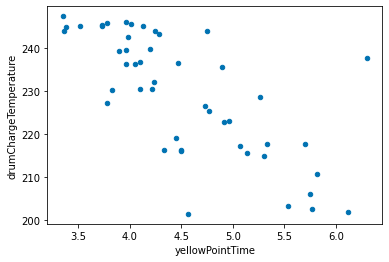

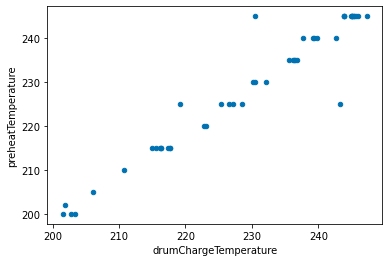

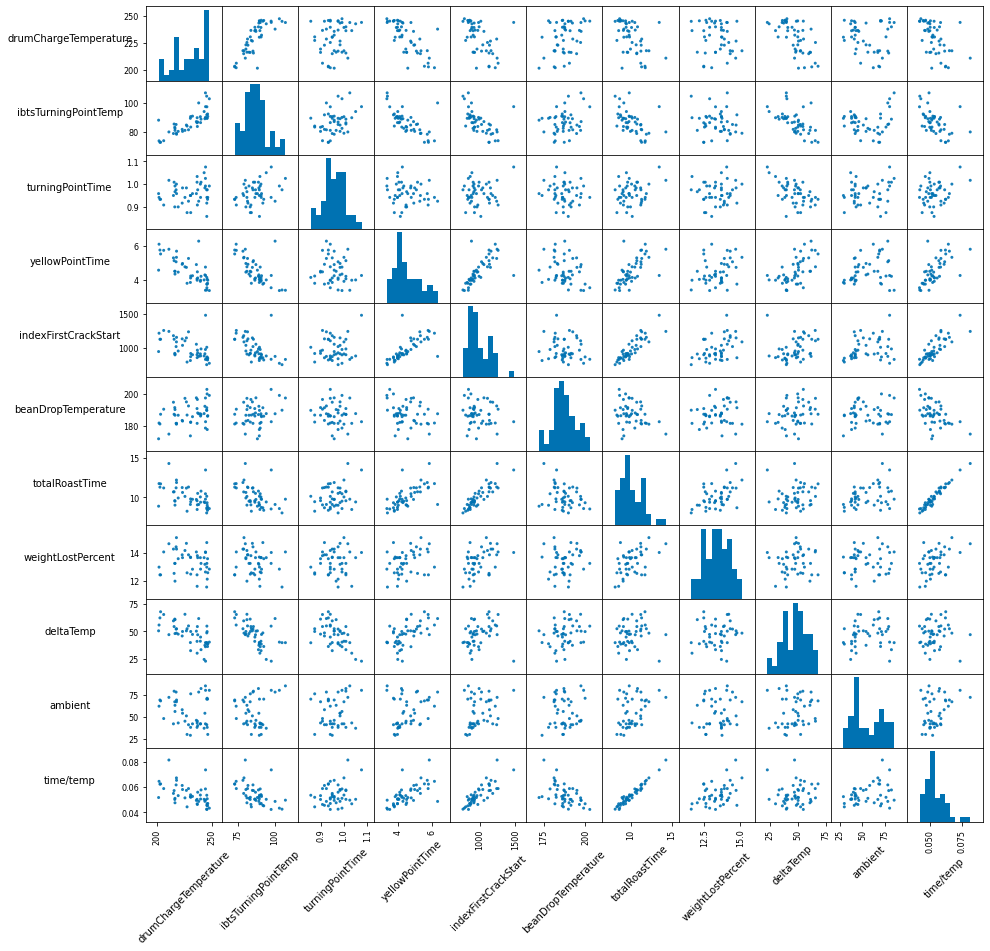

In [27]:
#####################    playing around with plot types and early observations as I learn
## Plot points_df  ##
#####################
# Bar Plot example
#point_df.plot.bar(x='roastName', y=["preheatTemperature","beanDropTemperature"])

# Box Plot example
#point_df['ibtsTurningPointTemp'].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)

# PH to yellowing pt relation
point_df.plot.scatter(x='yellowPointTime', y='drumChargeTemperature')  #['indexYellowingStart', 'indexFirstCrackStart', 'roastEndIndex'])
# shows errors in recording actualy preheat temp (or charging too early)
point_df.plot.scatter(x='drumChargeTemperature', y='preheatTemperature') 

# difference between thermal probes
#point_df.plot.scatter(x= 'beanChargeTemperature', y='drumChargeTemperature')  
plt.show()

# colored scatter example
#iFCS = point_df['indexFirstCrackStart']/120
#plt.scatter(iFCS, point_df['drumChargeTemperature'], 
#            s=point_df['drumDropTemperature'], c=point_df['roastEndIndex'], alpha=0.5)
#plt.xlabel('First Crack Start (mins)')
#plt.ylabel('Preheat Temp (℃)')
#plt.show()

# Scatter Matrix 
from pandas.plotting import scatter_matrix 
# selecting  numerical features 
features = [ 'drumChargeTemperature', 'ibtsTurningPointTemp', 'turningPointTime', 'yellowPointTime',
            'indexFirstCrackStart', 'beanDropTemperature','totalRoastTime','weightLostPercent',
            'deltaTemp', 'ambient', 'time/temp']
sm = scatter_matrix(point_df[features], range_padding= .5, alpha = .9, figsize=(15,15))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

plt.show() 

In [28]:
## finding outliers and specific beans from above
display (df.loc[(df.weightLostPercent > 15),['roastName', 'weightGreen', 'weightRoasted', 'weightLostPercent']])
print ('\n kenyans')
for n in point_df.roastName:
    if n.__contains__("kenya") or n.__contains__("Kenya"):
        print (n)
print ('\n short roasts, less than 8 min')   
display (point_df.loc[(point_df.totalRoastTime) < 8,['roastName']])

print ('\n high pre-heat outliers')   
display (point_df.loc[(point_df.preheatTemperature) > 260,['roastName', 'preheatTemperature','drumChargeTemperature']])

print ('\n charge temp  < 205 C')
display (point_df.loc[(point_df.drumChargeTemperature) < 205,['roastName', 'preheatTemperature','drumChargeTemperature']])


,roastName,weightGreen,weightRoasted,weightLostPercent
29,#24 PNG Barioda Estate 2nd Actual,490,416.0,15.102041



 kenyans
#13 Kenya Nyeri Githiru AA
# 25 Kenya Mix 350/140
# 25 Kenya Mix 350/140
#33 Kenya Gakuyu-Ini AA
#34 Kenya - Soak and watch
#35 Kenya no soak - FC stall, balls
#37 Kenya - fast start. always stalls
#44 Kenya - Rao suggestion
#45 Kenya Rao's with little to no fan. still crashed 40s after FC
#48 Kenya - dip to fix crash
#49 Kenya playback
#50 Kenya Recipie off 48

 short roasts, less than 8 min


,roastName



 high pre-heat outliers


,roastName,preheatTemperature,drumChargeTemperature



 charge temp  < 205 C


,roastName,preheatTemperature,drumChargeTemperature
9,#11 Ethiopia Agaro Nano Challa w/ Rob,200,201.5
16,#21 Ethiopia Genji Challa,202,201.9
21,# 25 Kenya Mix 350/140,200,202.7
22,# 25 Kenya Mix 350/140,200,203.3


In [48]:
# Linear Regression with scipy - try another method too
import matplotlib.pyplot as plt
from scipy import stats

## bean id ##
# Kenyan Gakuyu-Ini    55c16e48-9b08-4b2f-93d5-8f8b089a5017
# Ethiopian Yirg   4a557687-d410-4ad2-b504-27b518a9a7ae
beans = ['55c16e48-9b08-4b2f-93d5-8f8b089a5017','4a557687-d410-4ad2-b504-27b518a9a7ae']
bean_df = point_df[point_df.beanId.isin(beans)]
### USER INPUTS FOR DF TO BE USED ###
df_no_missing = bean_df[['drumChargeTemperature','weightLostPercent','drumDropTemperature','beanId',
                         'roastName','yellowPointTime','ibtsTurningPointTemp', 'totalRoastTime']].dropna()
allbean_df = point_df[['drumChargeTemperature','drumDropTemperature','beanId','roastName',
                       'yellowPointTime', 'ibtsTurningPointTemp', 'firstCrackTime',
                       'totalRoastTime','ambient']].dropna()
def OriginDataFrame (sourceDF,originCountry):
    global origin_df
    origin_list = []
    origin_df = pd.DataFrame() 
    for n in sourceDF.roastName:
        if str.lower(originCountry) in str.lower(n):
            origin_list.append(n)
    if len(origin_list) == 0:
        print (f'\n{originCountry} not in sourceDF, check!')
    origin_df = sourceDF[sourceDF.roastName.isin(origin_list)]


# define Function for Linear Regression
def LinearRegression(sourceDF, x_name, y_name, title):
    """creates a simple linera regression plot with 4 inputs"""
    if len(sourceDF) == 0 :
        print ('sourceDF is empty, select another df for regression \n')
    else:
        x= sourceDF[x_name]; y= sourceDF[y_name]
        slope, intercept, r, p, std_err = stats.linregress(x, y)
        print ('\n\n')
        print (stats.linregress(x, y) )
        def myfunc(x):
          return slope * x + intercept
        mymodel = list(map(myfunc, x))
        plt.title(title)
        xunit = ''
        yunit = ''
        if 'time' in str.lower(x_name):
            xunit = '(mins)'
        elif 'temp' in str.lower(x_name):
            xunit = '(℃)'
        elif 'ambient' in str.lower(x_name):
            xunit = '(℉)'
        else:
            xunit = ''
        if 'time' in str.lower(y_name):
            yunit = '(mins)'
        elif 'temp' in str.lower(y_name):
            yunit = '(℃)'
        elif 'ambient' in str.lower(y_name):
            yunit = '(℉)'
        else:
            yunit = ''   
        plt.xlabel(f'{x_name} {xunit}')
        plt.ylabel(f'{y_name} {yunit}')  # (℉) ℃
        plt.scatter(x, y)
        plt.plot(x, mymodel)
        plt.show()
   




LinregressResult(slope=3.517661419796347, intercept=158.38526198881073, rvalue=0.878985211545441, pvalue=7.358473308164923e-06, stderr=0.5100225207787937)


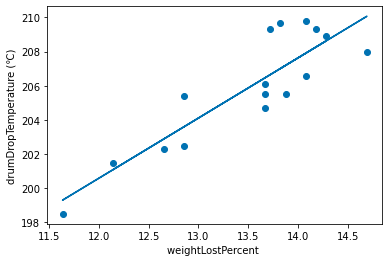




LinregressResult(slope=-3.111264729706273, intercept=112.072980591824, rvalue=-0.5167488639576908, pvalue=0.0004589044548679582, stderr=0.815024606004856)


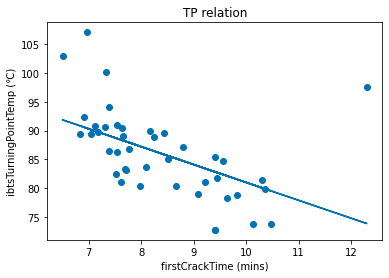




LinregressResult(slope=0.528181179775281, intercept=0.11756378745318141, rvalue=0.925956741275029, pvalue=5.586100855781803e-06, stderr=0.06494742067329046)


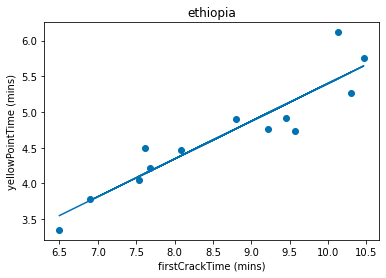

Text(0, 0.5, 'yellowPointTime (mins)')

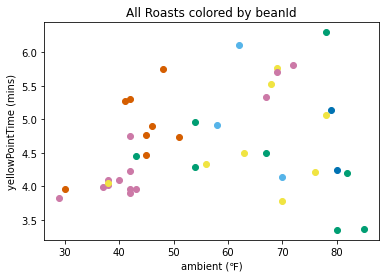

In [49]:
#############################
# Plotting LinearRegression #
#############################

## def LinearRegression(sourceDF, x_name, y_name, title):
# Regression 1 - Yellow Points
LinearRegression(df_no_missing,'weightLostPercent','drumDropTemperature','')  

# Regression 2 - Turning Points
LinearRegression(allbean_df,'firstCrackTime','ibtsTurningPointTemp','TP relation')  

#def OriginDataFrame (sourceDF,originCountry):
# Regression 3 - Origins
origin = 'ethiopia'
OriginDataFrame (allbean_df, origin )
LinearRegression(origin_df,'firstCrackTime','yellowPointTime', origin)  


# plot for all roasts no regression
x_name = 'ambient'
y_name = 'yellowPointTime'
groups = allbean_df.groupby('beanId')
for name, group in groups:
    plt.plot(group[x_name], group[y_name], marker='o', linestyle='', markersize=6, label=name)
plt.title('All Roasts colored by beanId')
plt.xlabel('ambient (℉)')
plt.ylabel('yellowPointTime (mins)')
#plt.legend()

1132 58187


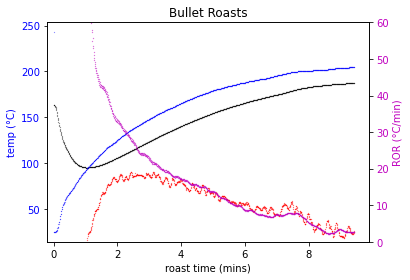

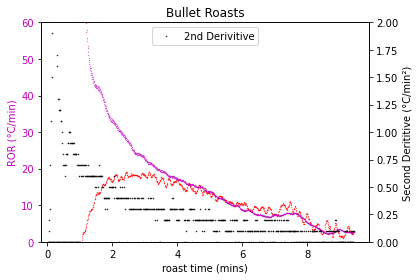

Roast plotted = ['#48 Kenya - dip to fix crash']


In [17]:
########################################################  # NEED TO-DO - tighten plots, maybe in groups relative to origin
## Creating full plot temp curves and associated RORs ##  
########################################################

# selecting specific roastName; many ways to select roasts here...  
roast_list = ['#48 Kenya - dip to fix crash']
plot_df = curve_df[curve_df.roastName.isin(roast_list)]

from cycler import cycler
temp_list = ['beanTemperature','drumTemperature']
derivative_list = ['beanDerivative','ibtsDerivative']

#plt.style.use('default')   #change for future
fig, ax1 = plt.subplots()

ax1.set_xlabel('roast time (mins)')
ax1.set_ylabel('temp (°C)', color='b')
ax1.set_prop_cycle(cycler('color', ['k', 'b']) + cycler('lw', [1, 2])) # necessary to set ax1 parameters before plot
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Bullet Roasts") 
ax1.scatter((plot_df.indexTime/sampleRate)/60, plot_df['beanTemperature'], label = 'Bean Temp', s=0.03)
ax1.scatter((plot_df.indexTime/sampleRate)/60, plot_df['drumTemperature'], label = 'Drum Temp', s=0.03)

print (len((plot_df.indexTime/sampleRate)/60), len(curve_df[temp_list]))

ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
ax2.set_ylabel('ROR (°C/min)', color='m')  # we already handled the x-label with ax1
ax2.set_prop_cycle(cycler('color', ['r', 'm']) + cycler('lw', [1, 2]))
ax2.scatter((plot_df.indexTime/sampleRate)/60, plot_df['beanDerivative'], label='ROR', s=0.05)
ax2.scatter((plot_df.indexTime/sampleRate)/60, plot_df['ibtsDerivative'], label='ROR', s=0.05)

ax2.tick_params(axis='y', labelcolor='m')
fig.tight_layout()  # otherwise the right y-label can be slightly clipped
plt.ylim([0, 60])
plt.xlim(left=-0.2)
#plt.legend(loc='upper center') # LATER display 4 labels, currently only ROR plots for 2 of 4 curves
plt.show()

############
# SECOND D # visualizing to understand challenges
############
from cycler import cycler
temp_list = ['beanTemperature','drumTemperature']
derivative_list = ['beanDerivative','ibtsDerivative']

fig, ax1 = plt.subplots()
ax1.set_xlabel('roast time (mins)')
ax1.set_ylabel('ROR (°C/min)', color='m')
ax1.set_prop_cycle(cycler('color', ['r', 'm']) + cycler('lw', [1, 2]))
ax1.tick_params(axis='y', labelcolor='m')
ax1.set_title("Bullet Roasts") 
ax1.scatter((plot_df.indexTime/sampleRate)/60, plot_df['beanDerivative'], label='ROR', s=0.05)
ax1.scatter((plot_df.indexTime/sampleRate)/60, plot_df['ibtsDerivative'], label='ROR', s=0.05)
plt.ylim([0, 60])

ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
marker_style = dict(marker = '.', linestyle='none', color='0.8', markersize=1,
                    mfc="C1", mec="k") #use linestyle='solid' once negative values removed and smoothed

ax2.set_ylabel(f'Second Derititive (°C/min\N{SUPERSCRIPT TWO})', color='k') 
ax2.plot((plot_df.indexTime/sampleRate)/60, plot_df['ibts2ndDerivative'], 
            label='2nd Derivitive', **marker_style) 
ax2.tick_params(axis='y', labelcolor='k')
fig.tight_layout()  # otherwise the right y-label can be slightly clipped
plt.ylim([0, 2])
plt.xlim(left=-0.2)
plt.legend(loc='upper center') # LATER display 4 labels, currently only ROR plots for 2 of 4 curves
plt.show()
print (f'Roast plotted = {roast_list}')


In [ ]:
## Things that didn't work
#autoYP2 = curve_df[(curve_df.index > indexTP) & (curve_df['drumTemperature'] >= 165) ,curve_df.index]
#print (autoYP2)

########
# things that did work or should do more
# display (np.sum(df.ambient == 0.0))
# df.ambient.replace(to_replace = 0.0, value = np.nan, inplace = True) 
##vectorized looping
